In [2]:
from scipy.special import comb
import math

In [8]:
def ensemble_error(n_classifier,error):
    k_start=int(math.ceil(n_classifier/2.))
#     math.ceil(x)  返回不小于x的最小整数
    probs=[comb(n_classifier,k)*error**k*(1-error)**(n_classifier-k) for k in range(k_start,n_classifier+1)]
    return sum(probs)

In [9]:
ensemble_error(n_classifier=11,error=0.25)

0.03432750701904297

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
error_range=np.arange(0.0,1.01,0.01)
ens_errors=[ensemble_error(n_classifier=11,error=error) for error in error_range]

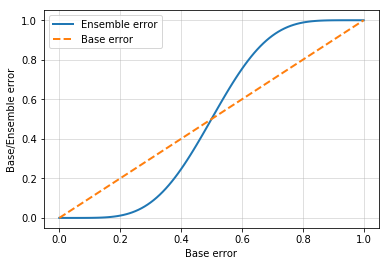

In [16]:
plt.plot(error_range,ens_errors,label='Ensemble error',linewidth=2)
plt.plot(error_range,error_range,linestyle='--',label='Base error',linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

In [17]:
# weighted majority vote
import numpy as np
np.argmax(np.bincount([0,0,1],weights=[0.2,0.2,0.6]))

1

In [19]:
# weighted majority bot based ono class probabilities
ex=np.array([[0.9,0.1],
             [0.8,0.2],
             [0.4,0.6]])

In [20]:
p=np.average(ex,axis=0,weights=[0.2,0.2,0.6])

In [21]:
p

array([0.58, 0.42])

In [24]:
# implement majorityvoteclassifier
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six   #与Python2.6兼容？
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

In [56]:
class MajorityVoteClassifier(BaseEstimator,ClassifierMixin):
#   通过父类得到一些已经定义好的函数：get_params set_params score
    """
    classifier:different classifiers for the ensemble
    vote: {'classlabel','probability'}
        if 'classlabel':
            the argmax of class labels
        elif 'probability':
            the argmax of the sum of probabilities is used to predict the class label
    
    weights:default:None (uniform weights)    
    """
    def __init__(self,classifiers,vote='classlabel',weights=None):
        self.classifiers=classifiers
        self.named_classifiers={key: value for key,value in _name_estimators(classifiers)}
        self.vote=vote
        self.weights=weights
    
    def fit(self,X,y):
        self.lablenc_ = LabelEncoder()   #user LabelEncoder来确保class labels从0开始，这对np.argmax是非常重要的
        self.lablenc_.fit(y)
        self.classes_=self.lablenc_.classes_
        self.classifiers_=[]
        for clf in self.classifiers:
            fitted_clf=clone(clf).fit(X,self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self,X):
        if self.vote == 'probability':
            maj_vote=np.argmax(self.predict_proba(X),axis=1)
        else:
            predictions=np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote=np.apply_along_axis(lambda x:np.argmax(np.bincount(x,weights=self.weights)),axis=1,arr=predictions)
        maj_vote=self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self,X):
        probas=np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba=np.average(probas,axis=0,weights=self.weights)
        return avg_proba
    
    def get_params(self,deep=True):
        if not deep:
            return super(MajorityVoteClassifier,self).get_params(deep=False)
        else:
            out=self.named_classifiers.copy()
            for name,step in six.iteritems(self.named_classifiers):
                for key,value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name,key)]=value
            return out

In [57]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [58]:
iris=datasets.load_iris()
X,y=iris.data[50:,[1,2]],iris.target[50:]
le=LabelEncoder()
y=le.fit_transform(y)

In [59]:
# the scikit-learn uses the predict_proba method to compute the ROC AUC score

In [60]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,random_state=1,stratify=y)

In [61]:
# 在把模型输入到ensemble分类器之前，先对每个模型做10-fold cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

In [62]:
clf1=LogisticRegression(penalty='l2',C=0.001,random_state=1)
clf2=DecisionTreeClassifier(max_depth=1,criterion='entropy',random_state=0)
clf3=KNeighborsClassifier(n_neighbors=1,p=2,metric='minkowski')
pipe1=Pipeline([['sc',StandardScaler()],['clf',clf1]])
pipe3=Pipeline([['sc',StandardScaler()],['clf',clf3]])
clf_labels=['Logistic regression','Decisiontree','KNN']

In [63]:
print('10-fold cross validation:\n')
for clf,label in zip([pipe1,clf2,pipe3],clf_labels):
    scores=cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
    print('ROC AUC:%0.2f (+/0 %0.2f)[%s]' % (scores.mean(),scores.std(),label))

10-fold cross validation:

ROC AUC:0.87 (+/0 0.17)[Logistic regression]
ROC AUC:0.89 (+/0 0.16)[Decisiontree]
ROC AUC:0.88 (+/0 0.15)[KNN]


D:\soft\Anaconda\envs\py3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\soft\Anaconda\envs\py3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\soft\Anaconda\envs\py3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\soft\Anaconda\envs\py3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\soft\Anaconda\envs\py3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

In [64]:
mv_clf=MajorityVoteClassifier(classifiers=[pipe1,clf2,pipe3])
clf_labels += ['Majority voting']
all_clf=[pipe1,clf2,pipe3,mv_clf]

In [65]:
for clf,label in zip(all_clf,clf_labels):
    scores=cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
    print('Accuracy: %0.2f (+/- % 0.2f)[%s]' % (scores.mean(),scores.std(),label))

Accuracy: 0.87 (+/-  0.17)[Logistic regression]
Accuracy: 0.89 (+/-  0.16)[Decisiontree]
Accuracy: 0.88 (+/-  0.15)[KNN]
Accuracy: 0.94 (+/-  0.13)[Majority voting]


D:\soft\Anaconda\envs\py3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\soft\Anaconda\envs\py3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\soft\Anaconda\envs\py3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\soft\Anaconda\envs\py3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\soft\Anaconda\envs\py3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

D:\soft\Anaconda\envs\py3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\soft\Anaconda\envs\py3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


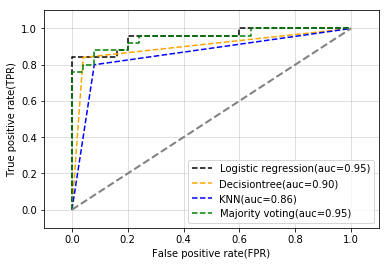

In [66]:
# compute the ROC curves from the test set
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
color=['black','orange','blue','green']
linestyles=['--','--','--','--']
for clf,label,clr,ls in zip(all_clf,clf_labels,color,linestyles):
    y_pred=clf.fit(X_train,y_train).predict_proba(X_test)[:,1]
    fpr,tpr,thresholds = roc_curve(y_true=y_test,y_score=y_pred)
    roc_auc=auc(x=fpr,y=tpr)
    plt.plot(fpr,tpr,color=clr,linestyle=ls,label='%s(auc=%0.2f)' % (label,roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],linestyle='--',color='gray',linewidth=2)
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate(FPR)')
plt.ylabel('True positive rate(TPR)')
plt.show()

D:\soft\Anaconda\envs\py3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\soft\Anaconda\envs\py3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


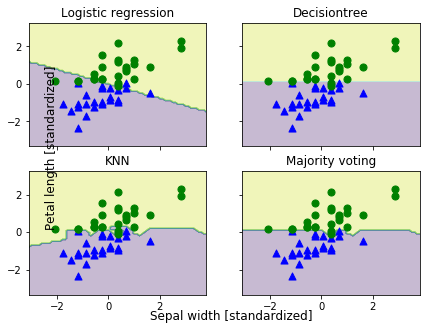

In [67]:
sc=StandardScaler()
X_train_std=sc.fit_transform(X_train)
from itertools import product
x_min = X_train_std[:,0].min()-1
x_max = X_train_std[:,0].max()+1
y_min = X_train_std[:,1].min()-1
y_max = X_train_std[:,1].max()+1
xx,yy = np.meshgrid(np.arange(x_min,x_max,0.1),np.arange(y_min,y_max,0.1))
f,axarr=plt.subplots(nrows=2,ncols=2,sharex='col',sharey='row',figsize=(7,5))
for idx,clf,tt in zip(product([0,1],[0,1]),all_clf,clf_labels):
    clf.fit(X_train_std,y_train)
    Z=clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z=Z.reshape(xx.shape)
    axarr[idx[0],idx[1]].contourf(xx,yy,Z,alpha=0.3)
    axarr[idx[0],idx[1]].scatter(X_train_std[y_train==0,0],X_train_std[y_train==0,1],c='blue',marker='^',s=50)
    axarr[idx[0],idx[1]].scatter(X_train_std[y_train==1,0],X_train_std[y_train==1,1],c='green',marker='o',s=50)
    axarr[idx[0],idx[1]].set_title(tt)
plt.text(-3.5,-4.5,s='Sepal width [standardized]',ha='center',va='center',fontsize=12)
plt.text(-10.5,4.5,s='Petal length [standardized]',ha='center',va='center',fontsize=12,rotation=90)
plt.show()

In [68]:
mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=1, solver='warn',
           tol=0.0001, verbose=0, warm_start=False)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'pipeline-2': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=Non

In [69]:
# tune the inverse regularization parameter C of the logistic regression classifier 
# and the decision tree depth via a grid search
from sklearn.model_selection import GridSearchCV

In [71]:
params={'decisiontreeclassifier__max_depth':[1,2],'pipeline-1__clf__C':[0.001,0.1,100.0]}
grid=GridSearchCV(estimator=mv_clf,param_grid=params,cv=10,scoring='roc_auc')
grid.fit(X_train,y_train)

D:\soft\Anaconda\envs\py3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\soft\Anaconda\envs\py3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\soft\Anaconda\envs\py3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\soft\Anaconda\envs\py3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\soft\Anaconda\envs\py3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2'...',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [96]:
print('Accuracy:%.2f' % grid.best_score_)

Accuracy:0.97


In [98]:
# bagging in action
import pandas as pd
df_wine=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None)

In [99]:
df_wine.columns=['Class label','Alcohol','Malic acid','Ash','Alcalinity of ash','Magnesium',
                'Total phenols','Flavanoids','Nonflavanoid phenols','Proanthocyanins','Color intensity',
                'Hue','OD280/OD315 of diluted wines','Proline']

In [102]:
np.bincount(df_wine['Class label'])

array([ 0, 59, 71, 48], dtype=int64)

In [103]:
df_wine['Class label'].value_counts()

2    71
1    59
3    48
Name: Class label, dtype: int64

In [104]:
df_wine=df_wine[df_wine['Class label'] != 1]

In [105]:
y=df_wine['Class label'].values
X=df_wine[['Alcohol','OD280/OD315 of diluted wines']].values

In [109]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le=LabelEncoder()
y=le.fit_transform(y)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1,stratify=y)

In [114]:
# bagging with sklearn
from sklearn.ensemble import BaggingClassifier
tree=DecisionTreeClassifier(criterion='entropy',random_state=1,max_depth=None)
bag=BaggingClassifier(base_estimator=tree,n_estimators=500,max_samples=1.0,max_features=1.0,
                      bootstrap=True,bootstrap_features=False,n_jobs=8,random_state=1)

In [115]:
from sklearn.metrics import accuracy_score
tree=tree.fit(X_train,y_train)
y_train_pred=tree.predict(X_train)
y_test_pred=tree.predict(X_test)
tree_train=accuracy_score(y_train,y_train_pred)
tree_test=accuracy_score(y_test,y_test_pred)

In [116]:
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train,tree_test))

Decision tree train/test accuracies 1.000/0.833


In [117]:
bag=bag.fit(X_train,y_train)
y_train_pred=bag.predict(X_train)
y_test_pred=bag.predict(X_test)
bag_train=accuracy_score(y_train,y_train_pred)
bag_test=accuracy_score(y_test,y_test_pred)

In [119]:
print('Bagging train/test accuracies %.3f/%.3f' % (bag_train,bag_test))

Bagging train/test accuracies 1.000/0.917


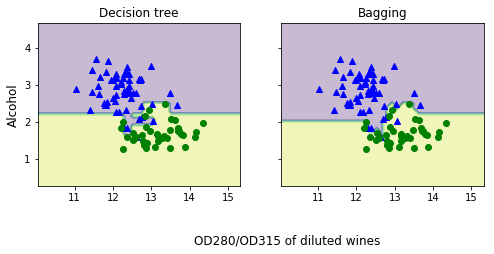

In [124]:
# 对比decision regions
x_min=X_train[:,0].min()-1
x_max=X_train[:,0].max()+1
y_min=X_train[:,1].min()-1
y_max=X_train[:,1].max()+1
xx,yy=np.meshgrid(np.arange(x_min,x_max,0.1),np.arange(y_min,y_max,0.1))
f,axarr=plt.subplots(nrows=1,ncols=2,sharex='col',sharey='row',figsize=(8,3))

for idx,clf,tt in zip([0,1],[tree,bag],['Decision tree','Bagging']):
    clf.fit(X_train,y_train)
    Z=clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z=Z.reshape(xx.shape)
    axarr[idx].contourf(xx,yy,Z,alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0,0],X_train[y_train==0,1],c='blue',marker='^')
    axarr[idx].scatter(X_train[y_train==1,0],X_train[y_train==1,1],c='green',marker='o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol',fontsize=12)
plt.text(10.2,-1.2,s='OD280/OD315 of diluted wines',ha='center',va='center',fontsize=12)
plt.show()

In [126]:
# adaboost in sklearn
from sklearn.ensemble import AdaBoostClassifier
tree=DecisionTreeClassifier(criterion='entropy',random_state=1,max_depth=1)
ada=AdaBoostClassifier(base_estimator=tree,n_estimators=500,learning_rate=0.1,random_state=1)
tree=tree.fit(X_train,y_train)
y_train_pred=tree.predict(X_train)
y_test_pred=tree.predict(X_test)
tree_train=accuracy_score(y_train,y_train_pred)
tree_test=accuracy_score(y_test,y_test_pred)

In [129]:
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train,tree_test))

Decision tree train/test accuracies 0.916/0.875


In [128]:
ada=ada.fit(X_train,y_train)
y_train_pred=ada.predict(X_train)
y_test_pred=ada.predict(X_test)
ada_train=accuracy_score(y_train,y_train_pred)
ada_test=accuracy_score(y_test,y_test_pred)

In [130]:
print('AdaBoost train/test accuracies %.3f/%.3f' % (ada_train,ada_test))

AdaBoost train/test accuracies 1.000/0.917
